<!-- (evaluation)= -->
# WeatherBench 2 Evaluation Quickstart

<a target="_blank" href="https://colab.research.google.com/github/google-research/weatherbench2/blob/main/docs/source/evaluation.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In this notebook, we will cover the basic functionality of the WeatherBench evaluation framework.

The WeatherBench evaluation framework takes two datasets for forecast and ground truth (called obs, even though reanalysis datasets like ERA5 are not observations), computes and saves the specified metrics.

Here, we will evalute ECMWF's HRES forecast against ERA5.

In [ ]:
# Pip might complain about the Pandas version. The notebook should still work as expected.
#!pip install git+https://github.com/google-research/weatherbench2.git

: 

In [1]:
#import apache_beam   # Needs to be imported separately to avoid TypingError
#import weatherbench2
import xarray as xr

In [2]:
# Run the code below to access cloud data on Colab!
#from google.colab import auth
#auth.authenticate_user()

### Specify input datasets

Let's take a look at the datasets. Currently, the WeatherBench pipeline requires all input dataset to be stored as Zarr files.

In [17]:
forecast_path = 'gs://weatherbench2/datasets/ifs_extended_range/weekly/ifs-ext-full-single-level-weekly_avg_ens_mean.zarr'
forecast_path_pressure = 'gs://weatherbench2/datasets/ifs_extended_range/weekly/ifs-ext-pressure-levels-weekly_avg_ens_mean.zarr'
ifs_reforecast_path = 'gs://weatherbench2/datasets/ifs_extended_range/weekly/ifs-ext-reforecast-pressure-levels-weekly_avg_ens_mean.zarr'
forecast_path_ifs_ens = "gs://weatherbench2/datasets/ifs_ens/2018-2022-240x121_equiangular_with_poles_conservative_mean.zarr"
ifs_raw_path = "gs://weatherbench2/datasets/ifs_extended_range/raw/ifs-ext-pressure-levels-inst-24h_ens_mean.zarr"
obs_path = 'gs://weatherbench2/datasets/era5_daily/1959-2023_01_10-1h-240x121_equiangular_with_poles_conservative.zarr'

#obs_path = 'gs://weatherbench2/datasets/era5/1959-2022-6h-64x32_equiangular_conservative.zarr'
#climatology_path = 'gs://weatherbench2/datasets/era5-hourly-climatology/1990-2019_6h_64x32_equiangular_conservative.zarr'

Generally, we follow ECMWF's naming conventions for the input files.

* `time` [np.datetime64]: Time at forecast is initialized
* `lead_time` or `prediction_timedelta` [np.timedelta64]: Lead time
* `latitude` [float]: Latitudes from -90 to 90
* `longitude` [float]: Longitudes from 0 to 360
* `level` [hPa]: Pressure levels (optional)

We don't actually need to open the forecast and obs datasets at this point, but we will do so here to see their structure.

In [5]:
xr.open_zarr(forecast_path)

<xarray.Dataset>
Dimensions:                                (time: 730,
                                            prediction_timedelta: 40,
                                            latitude: 121, longitude: 240)
Coordinates:
  * latitude                               (latitude) float32 -90.0 ... 90.0
  * longitude                              (longitude) float32 0.0 1.5 ... 358.5
  * prediction_timedelta                   (prediction_timedelta) timedelta64[ns] ...
  * time                                   (time) datetime64[ns] 2016-01-04 ....
    valid_time                             (time, prediction_timedelta) datetime64[ns] dask.array<chunksize=(730, 40), meta=np.ndarray>
Data variables: (12/18)
    2m_dewpoint_temperature                (time, prediction_timedelta, latitude, longitude) float32 dask.array<chunksize=(1, 14, 121, 240), meta=np.ndarray>
    2m_temperature                         (time, prediction_timedelta, latitude, longitude) float32 dask.array<chunksize=(1, 14, 121, 240), meta=np.ndarray>
    2m_temperature_max                     (time, prediction_timedelta, latitude, longitude) float32 dask.array<chunksize=(1, 14, 121, 240), meta=np.ndarray>
    2m_temperature_min                     (time, prediction_timedelta, latitude, longitude) float32 dask.array<chunksize=(1, 14, 121, 240), meta=np.ndarray>
    convective_available_potential_energy  (time, prediction_timedelta, latitude, longitude) float32 dask.array<chunksize=(1, 14, 121, 240), meta=np.ndarray>
    sea_ice_cover                          (time, prediction_timedelta, latitude, longitude) float32 dask.array<chunksize=(1, 14, 121, 240), meta=np.ndarray>
    ...                                     ...
    soil_moisture_top_20cm                 (time, prediction_timedelta, latitude, longitude) float32 dask.array<chunksize=(1, 14, 121, 240), meta=np.ndarray>
    soil_temperature_top_100cm             (time, prediction_timedelta, latitude, longitude) float32 dask.array<chunksize=(1, 14, 121, 240), meta=np.ndarray>
    soil_temperature_top_20cm              (time, prediction_timedelta, latitude, longitude) float32 dask.array<chunksize=(1, 14, 121, 240), meta=np.ndarray>
    total_cloud_cover                      (time, prediction_timedelta, latitude, longitude) float32 dask.array<chunksize=(1, 14, 121, 240), meta=np.ndarray>
    total_column_water                     (time, prediction_timedelta, latitude, longitude) float32 dask.array<chunksize=(1, 14, 121, 240), meta=np.ndarray>
    total_precipitation_24hr               (time, prediction_timedelta, latitude, longitude) float32 dask.array<chunksize=(1, 14, 121, 240), meta=np.ndarray>

In [6]:
ifs_week = xr.open_zarr(forecast_path_pressure)
ifs_week

<xarray.Dataset>
Dimensions:               (time: 730, prediction_timedelta: 41, level: 10,
                           latitude: 121, longitude: 240)
Coordinates:
  * latitude              (latitude) float32 -90.0 -88.5 -87.0 ... 88.5 90.0
  * level                 (level) int32 10 50 100 200 300 500 700 850 925 1000
  * longitude             (longitude) float32 0.0 1.5 3.0 ... 355.5 357.0 358.5
  * prediction_timedelta  (prediction_timedelta) timedelta64[ns] 0 days ... 4...
  * time                  (time) datetime64[ns] 2016-01-04 ... 2022-12-29
    valid_time            (time, prediction_timedelta) datetime64[ns] dask.array<chunksize=(730, 41), meta=np.ndarray>
Data variables:
    geopotential          (time, prediction_timedelta, level, latitude, longitude) float32 dask.array<chunksize=(1, 14, 1, 121, 240), meta=np.ndarray>
    specific_humidity     (time, prediction_timedelta, level, latitude, longitude) float32 dask.array<chunksize=(1, 14, 1, 121, 240), meta=np.ndarray>
    temperature           (time, prediction_timedelta, level, latitude, longitude) float32 dask.array<chunksize=(1, 14, 1, 121, 240), meta=np.ndarray>
    u_component_of_wind   (time, prediction_timedelta, level, latitude, longitude) float32 dask.array<chunksize=(1, 14, 1, 121, 240), meta=np.ndarray>
    v_component_of_wind   (time, prediction_timedelta, level, latitude, longitude) float32 dask.array<chunksize=(1, 14, 1, 121, 240), meta=np.ndarray>

In [7]:
ifs_ens = xr.open_zarr(forecast_path_ifs_ens)
ifs_ens

<xarray.Dataset>
Dimensions:                   (time: 3652, prediction_timedelta: 61,
                               longitude: 240, latitude: 121, level: 3)
Coordinates:
  * latitude                  (latitude) float64 -90.0 -88.5 -87.0 ... 88.5 90.0
  * level                     (level) int32 500 700 850
  * longitude                 (longitude) float64 0.0 1.5 3.0 ... 357.0 358.5
  * prediction_timedelta      (prediction_timedelta) timedelta64[ns] 00:00:00...
  * time                      (time) datetime64[ns] 2018-01-01 ... 2022-12-31...
Data variables: (12/15)
    10m_u_component_of_wind   (time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(1, 8, 240, 121), meta=np.ndarray>
    10m_v_component_of_wind   (time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(1, 8, 240, 121), meta=np.ndarray>
    10m_wind_speed            (time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(1, 8, 240, 121), meta=np.ndarray>
    2m_temperature            (time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(1, 8, 240, 121), meta=np.ndarray>
    geopotential              (time, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(1, 8, 3, 240, 121), meta=np.ndarray>
    mean_sea_level_pressure   (time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(1, 8, 240, 121), meta=np.ndarray>
    ...                        ...
    total_precipitation       (time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(1, 8, 240, 121), meta=np.ndarray>
    total_precipitation_24hr  (time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(1, 8, 240, 121), meta=np.ndarray>
    total_precipitation_6hr   (time, prediction_timedelta, longitude, latitude) float32 dask.array<chunksize=(1, 8, 240, 121), meta=np.ndarray>
    u_component_of_wind       (time, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(1, 8, 3, 240, 121), meta=np.ndarray>
    v_component_of_wind       (time, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(1, 8, 3, 240, 121), meta=np.ndarray>
    wind_speed                (time, prediction_timedelta, level, longitude, latitude) float32 dask.array<chunksize=(1, 8, 3, 240, 121), meta=np.ndarray>

In [8]:
ifs_raw = xr.open_zarr(ifs_raw_path)
ifs_raw

<xarray.Dataset>
Dimensions:               (time: 730, prediction_timedelta: 47, level: 10,
                           latitude: 121, longitude: 240)
Coordinates:
  * latitude              (latitude) float32 -90.0 -88.5 -87.0 ... 88.5 90.0
  * level                 (level) int32 10 50 100 200 300 500 700 850 925 1000
  * longitude             (longitude) float32 0.0 1.5 3.0 ... 355.5 357.0 358.5
  * prediction_timedelta  (prediction_timedelta) timedelta64[ns] 0 days ... 4...
  * time                  (time) datetime64[ns] 2016-01-04 ... 2022-12-29
    valid_time            (time, prediction_timedelta) datetime64[ns] dask.array<chunksize=(365, 47), meta=np.ndarray>
Data variables:
    geopotential          (time, prediction_timedelta, level, latitude, longitude) float32 dask.array<chunksize=(1, 23, 1, 121, 240), meta=np.ndarray>
    specific_humidity     (time, prediction_timedelta, level, latitude, longitude) float32 dask.array<chunksize=(1, 23, 1, 121, 240), meta=np.ndarray>
    temperature           (time, prediction_timedelta, level, latitude, longitude) float32 dask.array<chunksize=(1, 23, 1, 121, 240), meta=np.ndarray>
    u_component_of_wind   (time, prediction_timedelta, level, latitude, longitude) float32 dask.array<chunksize=(1, 23, 1, 121, 240), meta=np.ndarray>
    v_component_of_wind   (time, prediction_timedelta, level, latitude, longitude) float32 dask.array<chunksize=(1, 23, 1, 121, 240), meta=np.ndarray>

In [18]:
ifs_reforecast_week = xr.open_zarr(ifs_reforecast_path)
ifs_reforecast_week

<xarray.Dataset>
Dimensions:               (forecast_time: 730, hindcast_year: 20,
                           prediction_timedelta: 41, level: 10, latitude: 121,
                           longitude: 240)
Coordinates:
  * forecast_time         (forecast_time) datetime64[ns] 2016-01-04 ... 2022-...
  * hindcast_year         (hindcast_year) int32 -20 -19 -18 -17 ... -4 -3 -2 -1
  * latitude              (latitude) float32 -90.0 -88.5 -87.0 ... 88.5 90.0
  * level                 (level) int32 10 50 100 200 300 500 700 850 925 1000
  * longitude             (longitude) float32 0.0 1.5 3.0 ... 355.5 357.0 358.5
  * prediction_timedelta  (prediction_timedelta) timedelta64[ns] 0 days ... 4...
    time                  (forecast_time, hindcast_year) datetime64[ns] dask.array<chunksize=(730, 20), meta=np.ndarray>
    valid_time            (forecast_time, hindcast_year, prediction_timedelta) datetime64[ns] dask.array<chunksize=(365, 10, 21), meta=np.ndarray>
Data variables:
    geopotential          (forecast_time, hindcast_year, prediction_timedelta, level, latitude, longitude) float32 dask.array<chunksize=(1, 1, 14, 1, 121, 240), meta=np.ndarray>
    specific_humidity     (forecast_time, hindcast_year, prediction_timedelta, level, latitude, longitude) float32 dask.array<chunksize=(1, 1, 14, 1, 121, 240), meta=np.ndarray>
    temperature           (forecast_time, hindcast_year, prediction_timedelta, level, latitude, longitude) float32 dask.array<chunksize=(1, 1, 14, 1, 121, 240), meta=np.ndarray>
    u_component_of_wind   (forecast_time, hindcast_year, prediction_timedelta, level, latitude, longitude) float32 dask.array<chunksize=(1, 1, 14, 1, 121, 240), meta=np.ndarray>
    v_component_of_wind   (forecast_time, hindcast_year, prediction_timedelta, level, latitude, longitude) float32 dask.array<chunksize=(1, 1, 14, 1, 121, 240), meta=np.ndarray>

In [11]:
ifs_raw.prediction_timedelta.values.astype('timedelta64[h]')

array([   0,   24,   48,   72,   96,  120,  144,  168,  192,  216,  240,
        264,  288,  312,  336,  360,  384,  408,  432,  456,  480,  504,
        528,  552,  576,  600,  624,  648,  672,  696,  720,  744,  768,
        792,  816,  840,  864,  888,  912,  936,  960,  984, 1008, 1032,
       1056, 1080, 1104], dtype='timedelta64[h]')

In [12]:
ifs_week.prediction_timedelta.values.astype('timedelta64[h]')

array([  0,  24,  48,  72,  96, 120, 144, 168, 192, 216, 240, 264, 288,
       312, 336, 360, 384, 408, 432, 456, 480, 504, 528, 552, 576, 600,
       624, 648, 672, 696, 720, 744, 768, 792, 816, 840, 864, 888, 912,
       936, 960], dtype='timedelta64[h]')

In [15]:
era_week = xr.open_zarr(obs_path)
era_week

<xarray.Dataset>
Dimensions:                                             (time: 23386,
                                                         longitude: 240,
                                                         latitude: 121,
                                                         level: 13)
Coordinates:
  * latitude                                            (latitude) float64 -9...
  * level                                               (level) int64 50 ... ...
  * longitude                                           (longitude) float64 0...
  * time                                                (time) datetime64[ns] ...
Data variables: (12/103)
    10m_u_component_of_wind                             (time, longitude, latitude) float32 dask.array<chunksize=(48, 240, 121), meta=np.ndarray>
    10m_u_component_of_wind_max                         (time, longitude, latitude) float32 dask.array<chunksize=(48, 240, 121), meta=np.ndarray>
    10m_u_component_of_wind_min                         (time, longitude, latitude) float32 dask.array<chunksize=(48, 240, 121), meta=np.ndarray>
    10m_v_component_of_wind                             (time, longitude, latitude) float32 dask.array<chunksize=(48, 240, 121), meta=np.ndarray>
    10m_v_component_of_wind_max                         (time, longitude, latitude) float32 dask.array<chunksize=(48, 240, 121), meta=np.ndarray>
    10m_v_component_of_wind_min                         (time, longitude, latitude) float32 dask.array<chunksize=(48, 240, 121), meta=np.ndarray>
    ...                                                  ...
    volumetric_soil_water_layer_3                       (time, longitude, latitude) float32 dask.array<chunksize=(48, 240, 121), meta=np.ndarray>
    volumetric_soil_water_layer_3_max                   (time, longitude, latitude) float32 dask.array<chunksize=(48, 240, 121), meta=np.ndarray>
    volumetric_soil_water_layer_3_min                   (time, longitude, latitude) float32 dask.array<chunksize=(48, 240, 121), meta=np.ndarray>
    volumetric_soil_water_layer_4                       (time, longitude, latitude) float32 dask.array<chunksize=(48, 240, 121), meta=np.ndarray>
    volumetric_soil_water_layer_4_max                   (time, longitude, latitude) float32 dask.array<chunksize=(48, 240, 121), meta=np.ndarray>
    volumetric_soil_water_layer_4_min                   (time, longitude, latitude) float32 dask.array<chunksize=(48, 240, 121), meta=np.ndarray>

In [18]:
print(ifs_week.level[:])
print(era_week.level[:])

<xarray.DataArray 'level' (level: 10)>
array([  10,   50,  100,  200,  300,  500,  700,  850,  925, 1000], dtype=int32)
Coordinates:
  * level    (level) int32 10 50 100 200 300 500 700 850 925 1000
<xarray.DataArray 'level' (level: 13)>
array([  50,  100,  150,  200,  250,  300,  400,  500,  600,  700,  850,  925,
       1000])
Coordinates:
  * level    (level) int64 50 100 150 200 250 300 400 500 600 700 850 925 1000


Some metrics like the ACC also require a climatology file. Refer to the paper for details on how this is computed.

In [24]:
#climatology = xr.open_zarr(climatology_path)
#climatology

### Visualise data

In [2]:
forecast_train_path = "gs://weatherbench2/datasets/ifs_extended_range/weekly/ifs-ext-reforecast-pressure-levels-weekly_avg_ens_mean.zarr"
forecast_test_path = "gs://weatherbench2/datasets/ifs_extended_range/weekly/ifs-ext-pressure-levels-weekly_avg_ens_mean.zarr"
obs_path = "gs://weatherbench2/datasets/era5_weekly/1959-2023_01_10-1h-240x121_equiangular_with_poles_conservative.zarr"

In [9]:
no_avg = "gs://weatherbench2/datasets/ifs_extended_range/weekly/ifs-ext-reforecast-pressure-levels-weekly_avg.zarr/"
no_avg_ds = xr.open_zarr(no_avg)
no_avg_ds

<xarray.Dataset>
Dimensions:               (forecast_time: 730, number: 10, hindcast_year: 20,
                           prediction_timedelta: 41, level: 10, latitude: 121,
                           longitude: 240)
Coordinates:
  * forecast_time         (forecast_time) datetime64[ns] 2016-01-04 ... 2022-...
  * hindcast_year         (hindcast_year) int32 -20 -19 -18 -17 ... -4 -3 -2 -1
  * latitude              (latitude) float32 -90.0 -88.5 -87.0 ... 88.5 90.0
  * level                 (level) int32 10 50 100 200 300 500 700 850 925 1000
  * longitude             (longitude) float32 0.0 1.5 3.0 ... 355.5 357.0 358.5
  * number                (number) int32 1 2 3 4 5 6 7 8 9 10
  * prediction_timedelta  (prediction_timedelta) timedelta64[ns] 0 days ... 4...
    time                  (forecast_time, hindcast_year) datetime64[ns] dask.array<chunksize=(730, 20), meta=np.ndarray>
    valid_time            (forecast_time, hindcast_year, prediction_timedelta) datetime64[ns] dask.array<chunksize=(365, 10, 21), meta=np.ndarray>
Data variables:
    geopotential          (forecast_time, number, hindcast_year, prediction_timedelta, level, latitude, longitude) float32 dask.array<chunksize=(1, 10, 1, 14, 1, 121, 240), meta=np.ndarray>
    specific_humidity     (forecast_time, number, hindcast_year, prediction_timedelta, level, latitude, longitude) float32 dask.array<chunksize=(1, 10, 1, 14, 1, 121, 240), meta=np.ndarray>
    temperature           (forecast_time, number, hindcast_year, prediction_timedelta, level, latitude, longitude) float32 dask.array<chunksize=(1, 10, 1, 14, 1, 121, 240), meta=np.ndarray>
    u_component_of_wind   (forecast_time, number, hindcast_year, prediction_timedelta, level, latitude, longitude) float32 dask.array<chunksize=(1, 10, 1, 14, 1, 121, 240), meta=np.ndarray>
    v_component_of_wind   (forecast_time, number, hindcast_year, prediction_timedelta, level, latitude, longitude) float32 dask.array<chunksize=(1, 10, 1, 14, 1, 121, 240), meta=np.ndarray>

In [3]:
forecast_train = xr.open_zarr(forecast_train_path)
forecast_test = xr.open_zarr(forecast_test_path)
obs = xr.open_zarr(obs_path)

In [8]:
forecast_train

<xarray.Dataset>
Dimensions:               (forecast_time: 730, hindcast_year: 20,
                           prediction_timedelta: 41, level: 10, latitude: 121,
                           longitude: 240)
Coordinates:
  * forecast_time         (forecast_time) datetime64[ns] 2016-01-04 ... 2022-...
  * hindcast_year         (hindcast_year) int32 -20 -19 -18 -17 ... -4 -3 -2 -1
  * latitude              (latitude) float32 -90.0 -88.5 -87.0 ... 88.5 90.0
  * level                 (level) int32 10 50 100 200 300 500 700 850 925 1000
  * longitude             (longitude) float32 0.0 1.5 3.0 ... 355.5 357.0 358.5
  * prediction_timedelta  (prediction_timedelta) timedelta64[ns] 0 days ... 4...
    time                  (forecast_time, hindcast_year) datetime64[ns] dask.array<chunksize=(730, 20), meta=np.ndarray>
    valid_time            (forecast_time, hindcast_year, prediction_timedelta) datetime64[ns] dask.array<chunksize=(365, 10, 21), meta=np.ndarray>
Data variables:
    geopotential          (forecast_time, hindcast_year, prediction_timedelta, level, latitude, longitude) float32 dask.array<chunksize=(1, 1, 14, 1, 121, 240), meta=np.ndarray>
    specific_humidity     (forecast_time, hindcast_year, prediction_timedelta, level, latitude, longitude) float32 dask.array<chunksize=(1, 1, 14, 1, 121, 240), meta=np.ndarray>
    temperature           (forecast_time, hindcast_year, prediction_timedelta, level, latitude, longitude) float32 dask.array<chunksize=(1, 1, 14, 1, 121, 240), meta=np.ndarray>
    u_component_of_wind   (forecast_time, hindcast_year, prediction_timedelta, level, latitude, longitude) float32 dask.array<chunksize=(1, 1, 14, 1, 121, 240), meta=np.ndarray>
    v_component_of_wind   (forecast_time, hindcast_year, prediction_timedelta, level, latitude, longitude) float32 dask.array<chunksize=(1, 1, 14, 1, 121, 240), meta=np.ndarray>

In [4]:
obs

<xarray.Dataset>
Dimensions:                                             (time: 23386,
                                                         longitude: 240,
                                                         latitude: 121,
                                                         level: 13)
Coordinates:
  * latitude                                            (latitude) float64 -9...
  * level                                               (level) int64 50 ... ...
  * longitude                                           (longitude) float64 0...
  * time                                                (time) datetime64[ns] ...
Data variables: (12/103)
    10m_u_component_of_wind                             (time, longitude, latitude) float32 dask.array<chunksize=(48, 240, 121), meta=np.ndarray>
    10m_u_component_of_wind_max                         (time, longitude, latitude) float32 dask.array<chunksize=(48, 240, 121), meta=np.ndarray>
    10m_u_component_of_wind_min                         (time, longitude, latitude) float32 dask.array<chunksize=(48, 240, 121), meta=np.ndarray>
    10m_v_component_of_wind                             (time, longitude, latitude) float32 dask.array<chunksize=(48, 240, 121), meta=np.ndarray>
    10m_v_component_of_wind_max                         (time, longitude, latitude) float32 dask.array<chunksize=(48, 240, 121), meta=np.ndarray>
    10m_v_component_of_wind_min                         (time, longitude, latitude) float32 dask.array<chunksize=(48, 240, 121), meta=np.ndarray>
    ...                                                  ...
    volumetric_soil_water_layer_3                       (time, longitude, latitude) float32 dask.array<chunksize=(48, 240, 121), meta=np.ndarray>
    volumetric_soil_water_layer_3_max                   (time, longitude, latitude) float32 dask.array<chunksize=(48, 240, 121), meta=np.ndarray>
    volumetric_soil_water_layer_3_min                   (time, longitude, latitude) float32 dask.array<chunksize=(48, 240, 121), meta=np.ndarray>
    volumetric_soil_water_layer_4                       (time, longitude, latitude) float32 dask.array<chunksize=(48, 240, 121), meta=np.ndarray>
    volumetric_soil_water_layer_4_max                   (time, longitude, latitude) float32 dask.array<chunksize=(48, 240, 121), meta=np.ndarray>
    volumetric_soil_water_layer_4_min                   (time, longitude, latitude) float32 dask.array<chunksize=(48, 240, 121), meta=np.ndarray>

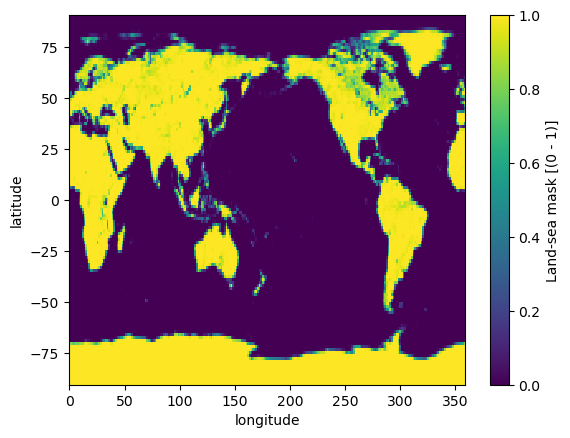

In [18]:
obs2_path ="gs://weatherbench2/datasets/era5/1959-2022-1h-240x121_equiangular_with_poles_conservative.zarr"
obs2 = xr.open_zarr(obs2_path)
obs2.land_sea_mask.T.plot()

In [26]:
obs2.latitude

<xarray.DataArray 'latitude' (latitude: 121)>
array([-90. , -88.5, -87. , -85.5, -84. , -82.5, -81. , -79.5, -78. , -76.5,
       -75. , -73.5, -72. , -70.5, -69. , -67.5, -66. , -64.5, -63. , -61.5,
       -60. , -58.5, -57. , -55.5, -54. , -52.5, -51. , -49.5, -48. , -46.5,
       -45. , -43.5, -42. , -40.5, -39. , -37.5, -36. , -34.5, -33. , -31.5,
       -30. , -28.5, -27. , -25.5, -24. , -22.5, -21. , -19.5, -18. , -16.5,
       -15. , -13.5, -12. , -10.5,  -9. ,  -7.5,  -6. ,  -4.5,  -3. ,  -1.5,
         0. ,   1.5,   3. ,   4.5,   6. ,   7.5,   9. ,  10.5,  12. ,  13.5,
        15. ,  16.5,  18. ,  19.5,  21. ,  22.5,  24. ,  25.5,  27. ,  28.5,
        30. ,  31.5,  33. ,  34.5,  36. ,  37.5,  39. ,  40.5,  42. ,  43.5,
        45. ,  46.5,  48. ,  49.5,  51. ,  52.5,  54. ,  55.5,  57. ,  58.5,
        60. ,  61.5,  63. ,  64.5,  66. ,  67.5,  69. ,  70.5,  72. ,  73.5,
        75. ,  76.5,  78. ,  79.5,  81. ,  82.5,  84. ,  85.5,  87. ,  88.5,
        90. ])
Coordinates:
  * latitude  (latitude) float64 -90.0 -88.5 -87.0 -85.5 ... 85.5 87.0 88.5 90.0

In [27]:
obs2.land_sea_mask.to_netcdf("/home/majanvie/scratch/data/raw/obs/land_sea_mask.nc")

In [37]:
import numpy as np 
np.unique(obs2.land_sea_mask.values) #.shape

array([0.0000000e+00, 1.0453896e-07, 1.0595874e-07, ..., 9.9999994e-01,
       1.0000000e+00, 1.0000001e+00], dtype=float32)

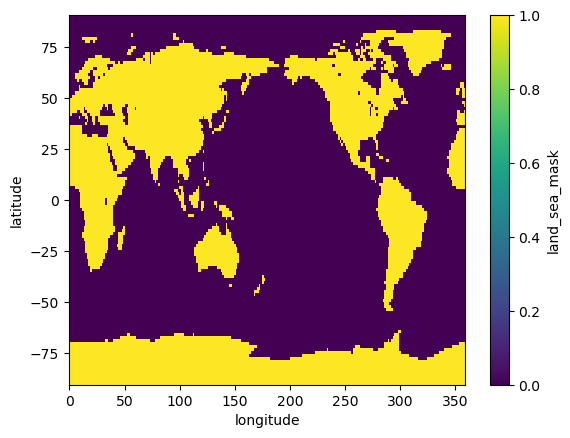

In [36]:
(obs2.land_sea_mask.T>0.5).plot()

In [15]:
import xarray as xr
train_path_ens = "gs://weatherbench2/datasets/ifs_extended_range/weekly/ifs-ext-reforecast-full-single-level-weekly_avg.zarr/"
test_path_ens = "gs://weatherbench2/datasets/ifs_extended_range/weekly/ifs-ext-full-single-level-weekly_avg.zarr"
forecast_train = xr.open_zarr(train_path_ens)
forecast_test = xr.open_zarr(test_path_ens)

subset = forecast_train.isel(
    hindcast_year=0,
    forecast_time=slice(0,20),
    prediction_timedelta=[0,7,14,21,28,35,39],)

subset_test = forecast_test.isel(
    time=slice(0,20),
    prediction_timedelta=[0,7,14,21,28,35,39],)
subset_test

<xarray.Dataset>
Dimensions:                                (time: 20, number: 50,
                                            prediction_timedelta: 7,
                                            latitude: 121, longitude: 240)
Coordinates:
  * latitude                               (latitude) float32 -90.0 ... 90.0
  * longitude                              (longitude) float32 0.0 1.5 ... 358.5
  * number                                 (number) int32 1 2 3 4 ... 48 49 50
  * prediction_timedelta                   (prediction_timedelta) timedelta64[ns] ...
  * time                                   (time) datetime64[ns] 2016-01-04 ....
    valid_time                             (time, prediction_timedelta) datetime64[ns] dask.array<chunksize=(20, 7), meta=np.ndarray>
Data variables: (12/18)
    2m_dewpoint_temperature                (time, number, prediction_timedelta, latitude, longitude) float32 dask.array<chunksize=(1, 50, 2, 121, 240), meta=np.ndarray>
    2m_temperature                         (time, number, prediction_timedelta, latitude, longitude) float32 dask.array<chunksize=(1, 50, 2, 121, 240), meta=np.ndarray>
    2m_temperature_max                     (time, number, prediction_timedelta, latitude, longitude) float32 dask.array<chunksize=(1, 50, 2, 121, 240), meta=np.ndarray>
    2m_temperature_min                     (time, number, prediction_timedelta, latitude, longitude) float32 dask.array<chunksize=(1, 50, 2, 121, 240), meta=np.ndarray>
    convective_available_potential_energy  (time, number, prediction_timedelta, latitude, longitude) float32 dask.array<chunksize=(1, 50, 2, 121, 240), meta=np.ndarray>
    sea_ice_cover                          (time, number, prediction_timedelta, latitude, longitude) float32 dask.array<chunksize=(1, 50, 2, 121, 240), meta=np.ndarray>
    ...                                     ...
    soil_moisture_top_20cm                 (time, number, prediction_timedelta, latitude, longitude) float32 dask.array<chunksize=(1, 50, 2, 121, 240), meta=np.ndarray>
    soil_temperature_top_100cm             (time, number, prediction_timedelta, latitude, longitude) float32 dask.array<chunksize=(1, 50, 2, 121, 240), meta=np.ndarray>
    soil_temperature_top_20cm              (time, number, prediction_timedelta, latitude, longitude) float32 dask.array<chunksize=(1, 50, 2, 121, 240), meta=np.ndarray>
    total_cloud_cover                      (time, number, prediction_timedelta, latitude, longitude) float32 dask.array<chunksize=(1, 50, 2, 121, 240), meta=np.ndarray>
    total_column_water                     (time, number, prediction_timedelta, latitude, longitude) float32 dask.array<chunksize=(1, 50, 2, 121, 240), meta=np.ndarray>
    total_precipitation_24hr               (time, number, prediction_timedelta, latitude, longitude) float32 dask.array<chunksize=(1, 50, 2, 121, 240), meta=np.ndarray>

In [16]:
subset

<xarray.Dataset>
Dimensions:                                (forecast_time: 20, number: 10,
                                            prediction_timedelta: 7,
                                            latitude: 121, longitude: 240)
Coordinates:
  * forecast_time                          (forecast_time) datetime64[ns] 201...
    hindcast_year                          int32 -20
  * latitude                               (latitude) float32 -90.0 ... 90.0
  * longitude                              (longitude) float32 0.0 1.5 ... 358.5
  * number                                 (number) int32 1 2 3 4 5 6 7 8 9 10
  * prediction_timedelta                   (prediction_timedelta) timedelta64[ns] ...
    time                                   (forecast_time) datetime64[ns] dask.array<chunksize=(20,), meta=np.ndarray>
    valid_time                             (forecast_time, prediction_timedelta) datetime64[ns] dask.array<chunksize=(20, 3), meta=np.ndarray>
Data variables: (12/18)
    2m_dewpoint_temperature                (forecast_time, number, prediction_timedelta, latitude, longitude) float32 dask.array<chunksize=(1, 10, 2, 121, 240), meta=np.ndarray>
    2m_temperature                         (forecast_time, number, prediction_timedelta, latitude, longitude) float32 dask.array<chunksize=(1, 10, 2, 121, 240), meta=np.ndarray>
    2m_temperature_max                     (forecast_time, number, prediction_timedelta, latitude, longitude) float32 dask.array<chunksize=(1, 10, 2, 121, 240), meta=np.ndarray>
    2m_temperature_min                     (forecast_time, number, prediction_timedelta, latitude, longitude) float32 dask.array<chunksize=(1, 10, 2, 121, 240), meta=np.ndarray>
    convective_available_potential_energy  (forecast_time, number, prediction_timedelta, latitude, longitude) float32 dask.array<chunksize=(1, 10, 2, 121, 240), meta=np.ndarray>
    sea_ice_cover                          (forecast_time, number, prediction_timedelta, latitude, longitude) float32 dask.array<chunksize=(1, 10, 2, 121, 240), meta=np.ndarray>
    ...                                     ...
    soil_moisture_top_20cm                 (forecast_time, number, prediction_timedelta, latitude, longitude) float32 dask.array<chunksize=(1, 10, 2, 121, 240), meta=np.ndarray>
    soil_temperature_top_100cm             (forecast_time, number, prediction_timedelta, latitude, longitude) float32 dask.array<chunksize=(1, 10, 2, 121, 240), meta=np.ndarray>
    soil_temperature_top_20cm              (forecast_time, number, prediction_timedelta, latitude, longitude) float32 dask.array<chunksize=(1, 10, 2, 121, 240), meta=np.ndarray>
    total_cloud_cover                      (forecast_time, number, prediction_timedelta, latitude, longitude) float32 dask.array<chunksize=(1, 10, 2, 121, 240), meta=np.ndarray>
    total_column_water                     (forecast_time, number, prediction_timedelta, latitude, longitude) float32 dask.array<chunksize=(1, 10, 2, 121, 240), meta=np.ndarray>
    total_precipitation_24hr               (forecast_time, number, prediction_timedelta, latitude, longitude) float32 dask.array<chunksize=(1, 10, 2, 121, 240), meta=np.ndarray>

In [6]:
forecast_train.latitude.values

array([-90. , -88.5, -87. , -85.5, -84. , -82.5, -81. , -79.5, -78. ,
       -76.5, -75. , -73.5, -72. , -70.5, -69. , -67.5, -66. , -64.5,
       -63. , -61.5, -60. , -58.5, -57. , -55.5, -54. , -52.5, -51. ,
       -49.5, -48. , -46.5, -45. , -43.5, -42. , -40.5, -39. , -37.5,
       -36. , -34.5, -33. , -31.5, -30. , -28.5, -27. , -25.5, -24. ,
       -22.5, -21. , -19.5, -18. , -16.5, -15. , -13.5, -12. , -10.5,
        -9. ,  -7.5,  -6. ,  -4.5,  -3. ,  -1.5,   0. ,   1.5,   3. ,
         4.5,   6. ,   7.5,   9. ,  10.5,  12. ,  13.5,  15. ,  16.5,
        18. ,  19.5,  21. ,  22.5,  24. ,  25.5,  27. ,  28.5,  30. ,
        31.5,  33. ,  34.5,  36. ,  37.5,  39. ,  40.5,  42. ,  43.5,
        45. ,  46.5,  48. ,  49.5,  51. ,  52.5,  54. ,  55.5,  57. ,
        58.5,  60. ,  61.5,  63. ,  64.5,  66. ,  67.5,  69. ,  70.5,
        72. ,  73.5,  75. ,  76.5,  78. ,  79.5,  81. ,  82.5,  84. ,
        85.5,  87. ,  88.5,  90. ], dtype=float32)

In [8]:
forecast_test.latitude.values

array([-90. , -88.5, -87. , -85.5, -84. , -82.5, -81. , -79.5, -78. ,
       -76.5, -75. , -73.5, -72. , -70.5, -69. , -67.5, -66. , -64.5,
       -63. , -61.5, -60. , -58.5, -57. , -55.5, -54. , -52.5, -51. ,
       -49.5, -48. , -46.5, -45. , -43.5, -42. , -40.5, -39. , -37.5,
       -36. , -34.5, -33. , -31.5, -30. , -28.5, -27. , -25.5, -24. ,
       -22.5, -21. , -19.5, -18. , -16.5, -15. , -13.5, -12. , -10.5,
        -9. ,  -7.5,  -6. ,  -4.5,  -3. ,  -1.5,   0. ,   1.5,   3. ,
         4.5,   6. ,   7.5,   9. ,  10.5,  12. ,  13.5,  15. ,  16.5,
        18. ,  19.5,  21. ,  22.5,  24. ,  25.5,  27. ,  28.5,  30. ,
        31.5,  33. ,  34.5,  36. ,  37.5,  39. ,  40.5,  42. ,  43.5,
        45. ,  46.5,  48. ,  49.5,  51. ,  52.5,  54. ,  55.5,  57. ,
        58.5,  60. ,  61.5,  63. ,  64.5,  66. ,  67.5,  69. ,  70.5,
        72. ,  73.5,  75. ,  76.5,  78. ,  79.5,  81. ,  82.5,  84. ,
        85.5,  87. ,  88.5,  90. ], dtype=float32)

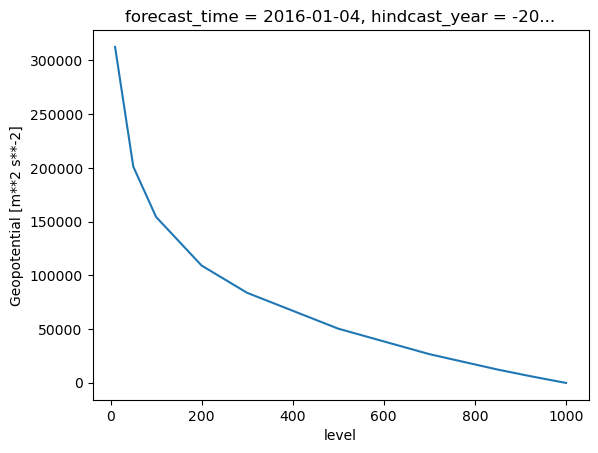

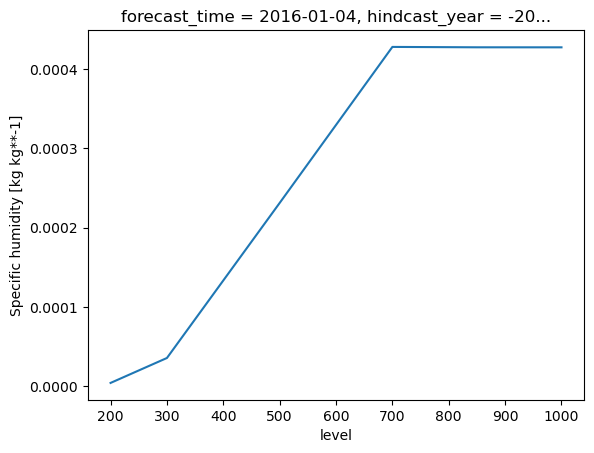

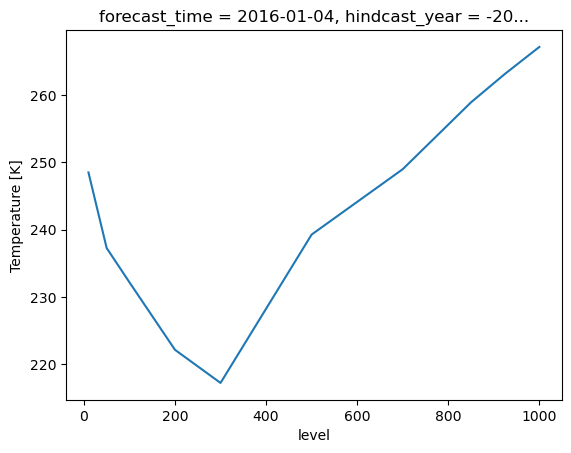

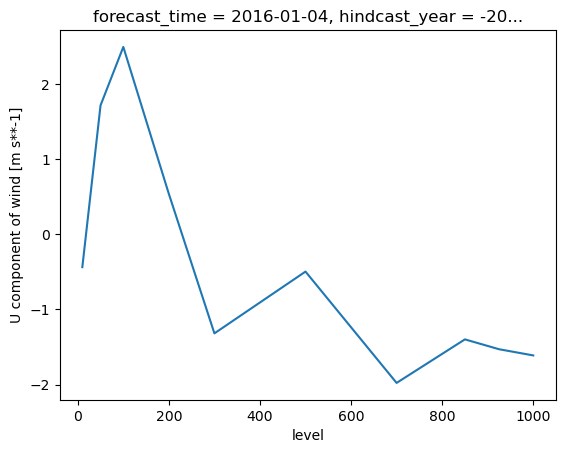

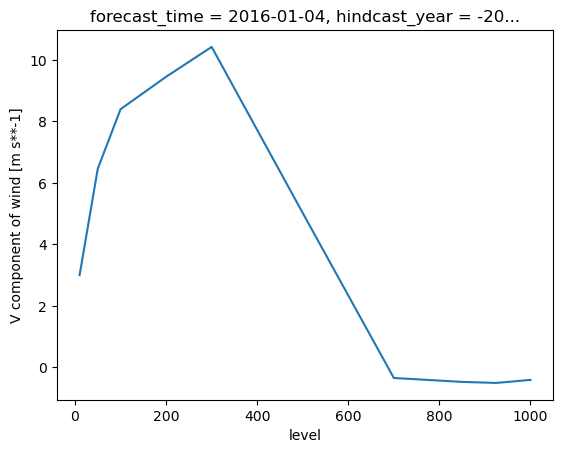

In [14]:
for var in forecast_train.data_vars:
    forecast_train[var].isel(forecast_time=0, hindcast_year=0, prediction_timedelta=0, latitude=0, longitude=0).plot()
    plt.show()
#forecast_train.isel(forecast_time=0, hindcast_year=1, prediction_timedelta=0, latitude=0, longitude=1)["geopotential"].plot()

In [21]:
forecast_train.isel(forecast_time=0, hindcast_year=0, prediction_timedelta=0, latitude=0, longitude=0) #.to_array().values

<xarray.Dataset>
Dimensions:               (level: 10)
Coordinates:
    forecast_time         datetime64[ns] 2016-01-04
    hindcast_year         int32 -20
    latitude              float32 -90.0
  * level                 (level) int32 10 50 100 200 300 500 700 850 925 1000
    longitude             float32 0.0
    prediction_timedelta  timedelta64[ns] 00:00:00
    time                  datetime64[ns] dask.array<chunksize=(), meta=np.ndarray>
    valid_time            datetime64[ns] dask.array<chunksize=(), meta=np.ndarray>
Data variables:
    geopotential          (level) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    specific_humidity     (level) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    temperature           (level) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    u_component_of_wind   (level) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    v_component_of_wind   (level) float32 dask.array<chunksize=(1,), meta=np.ndarray>

In [39]:
mask = forecast_train["specific_humidity"].isel(level=[0,1,2])
all_nan = mask.isnull().all()

# Check if all elements in the DataArray are True (i.e., all values are NaN)
all_nan_values = all_nan.compute().all()

print("All values are NaN:", all_nan_values)



KeyboardInterrupt: 

In [44]:
all_nan_values = mask.isnull().all(dim=['forecast_time', 'prediction_timedelta', 'latitude', 'longitude', 'hindcast_year']) #.all(dim='level')
all_nan_values

<xarray.DataArray 'specific_humidity' (level: 3)>
dask.array<all-aggregate, shape=(3,), dtype=bool, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
  * level    (level) int32 10 50 100

In [51]:
forecast_train["specific_humidity"].isel(level=[0,1,2]).min().compute()


/home/majanvie/miniconda3/envs/pytorch_env/lib/python3.12/site-packages/dask/array/reductions.py:621: RuntimeWarning: All-NaN slice encountered
  return np.nanmin(x_chunk, axis=axis, keepdims=keepdims)
/home/majanvie/miniconda3/envs/pytorch_env/lib/python3.12/site-packages/dask/array/reductions.py:621: RuntimeWarning: All-NaN slice encountered
  return np.nanmin(x_chunk, axis=axis, keepdims=keepdims)


<xarray.DataArray 'specific_humidity' ()>
array(nan, dtype=float32)

In [55]:
import numpy.ma as ma
import numpy as np
data_array = forecast_train["specific_humidity"].isel(forecast_time=0, hindcast_year=0, prediction_timedelta=0, latitude=0, longitude=0).values
# Mask the array where NaNs are present
masked_array = ma.masked_array(data_array, np.isnan(data_array))

print("Masked array:")
print(masked_array)

Masked array:
[-- -- -- 4.343203272583196e-06 3.5773031413555145e-05
 0.00023120769765228033 0.0004278659471310675 0.00042738550109788775
 0.00042736221803352237 0.0004273451922927052]


In [58]:
data = forecast_train.isel(hindcast_year=0, prediction_timedelta=28, forecast_time=4).to_array().values
data

array([[[[ 3.05655781e+05,  3.05655781e+05,  3.05655781e+05, ...,
           3.05655781e+05,  3.05655781e+05,  3.05655781e+05],
         [ 3.05624656e+05,  3.05624750e+05,  3.05624656e+05, ...,
           3.05624938e+05,  3.05624875e+05,  3.05624812e+05],
         [ 3.05596125e+05,  3.05596125e+05,  3.05596188e+05, ...,
           3.05596375e+05,  3.05596156e+05,  3.05596031e+05],
         ...,
         [ 2.86574750e+05,  2.86558062e+05,  2.86542250e+05, ...,
           2.86628812e+05,  2.86610031e+05,  2.86592031e+05],
         [ 2.87091938e+05,  2.87082812e+05,  2.87074000e+05, ...,
           2.87121812e+05,  2.87111469e+05,  2.87101531e+05],
         [ 2.87695281e+05,  2.87695281e+05,  2.87695281e+05, ...,
           2.87695281e+05,  2.87695281e+05,  2.87695281e+05]],

        [[ 1.98783125e+05,  1.98783125e+05,  1.98783125e+05, ...,
           1.98783125e+05,  1.98783125e+05,  1.98783125e+05],
         [ 1.98764438e+05,  1.98762859e+05,  1.98761344e+05, ...,
           1.98769250e

In [71]:
reshaped = data.reshape(-1, data.shape[2], data.shape[3])
reshaped[:,0,0]

array([ 3.0565578e+05,  1.9878312e+05,  1.5330836e+05,  1.0822346e+05,
        8.2688016e+04,  4.9577316e+04,  2.6308793e+04,  1.2222381e+04,
        5.9241104e+03,  2.4225178e+01,            nan,            nan,
                  nan,  2.9295225e-06,  2.8403630e-05,  1.8773772e-04,
        1.3759034e-04,  1.3745329e-04,  1.3748788e-04,  1.3746126e-04,
        2.3832841e+02,  2.2859085e+02,  2.2786922e+02,  2.2375435e+02,
        2.1703101e+02,  2.3601880e+02,  2.3901334e+02,  2.4864816e+02,
        2.5280452e+02,  2.5664532e+02, -1.4989374e+00, -9.2228222e-01,
       -6.5707743e-01, -1.2529160e+00, -2.9147670e+00, -1.3037208e+00,
       -3.6686015e+00, -2.9852924e+00, -3.1355374e+00, -3.1695647e+00,
        7.4789512e-01,  2.7002156e+00,  3.7062607e+00,  3.8362255e+00,
        3.6832168e+00,  4.2205963e-01, -1.1547154e+00, -1.5433558e+00,
       -1.5056033e+00, -1.4734149e+00], dtype=float32)

In [73]:
drop_nan = reshaped[~np.isnan(reshaped).all(axis=(1,2))]
drop_nan.shape

(47, 121, 240)

In [75]:
drop_nan[:,0,0]

array([ 3.0565578e+05,  1.9878312e+05,  1.5330836e+05,  1.0822346e+05,
        8.2688016e+04,  4.9577316e+04,  2.6308793e+04,  1.2222381e+04,
        5.9241104e+03,  2.4225178e+01,  2.9295225e-06,  2.8403630e-05,
        1.8773772e-04,  1.3759034e-04,  1.3745329e-04,  1.3748788e-04,
        1.3746126e-04,  2.3832841e+02,  2.2859085e+02,  2.2786922e+02,
        2.2375435e+02,  2.1703101e+02,  2.3601880e+02,  2.3901334e+02,
        2.4864816e+02,  2.5280452e+02,  2.5664532e+02, -1.4989374e+00,
       -9.2228222e-01, -6.5707743e-01, -1.2529160e+00, -2.9147670e+00,
       -1.3037208e+00, -3.6686015e+00, -2.9852924e+00, -3.1355374e+00,
       -3.1695647e+00,  7.4789512e-01,  2.7002156e+00,  3.7062607e+00,
        3.8362255e+00,  3.6832168e+00,  4.2205963e-01, -1.1547154e+00,
       -1.5433558e+00, -1.5056033e+00, -1.4734149e+00], dtype=float32)

In [52]:
forecast_train["specific_humidity"].isel(level=[0,1,2]).max().compute()

<xarray.DataArray 'specific_humidity' ()>
array(nan, dtype=float32)

In [50]:
forecast_train["specific_humidity"].isel(level=[0,1,2]).isel(forecast_time=67, hindcast_year=6, prediction_timedelta=24, latitude=9, longitude=10).values.max()

nan

In [37]:
# Stack the dimensions to create a DataArray of indices
stacked_nan = nan_mask.stack(z=('dim1', 'dim2', 'dim3'))

<xarray.DataArray 'specific_humidity' (hindcast_year: 20,
                                       prediction_timedelta: 41, level: 3,
                                       latitude: 121, longitude: 240)>
dask.array<getitem, shape=(20, 41, 3, 121, 240), dtype=bool, chunksize=(1, 14, 1, 121, 240), chunktype=numpy.ndarray>
Coordinates:
    forecast_time         datetime64[ns] 2020-10-19
  * hindcast_year         (hindcast_year) int32 -20 -19 -18 -17 ... -4 -3 -2 -1
  * latitude              (latitude) float32 -90.0 -88.5 -87.0 ... 88.5 90.0
  * level                 (level) int32 10 50 100
  * longitude             (longitude) float32 0.0 1.5 3.0 ... 355.5 357.0 358.5
  * prediction_timedelta  (prediction_timedelta) timedelta64[ns] 0 days ... 4...
    time                  (hindcast_year) datetime64[ns] dask.array<chunksize=(20,), meta=np.ndarray>
    valid_time            (hindcast_year, prediction_timedelta) datetime64[ns] dask.array<chunksize=(10, 21), meta=np.ndarray>

In [17]:
nan_mask = forecast_train.isnull().any(dim=['latitude', 'longitude', 'level', 'forecast_time', 'hindcast_year', 'prediction_timedelta'])
nan_mask

<xarray.Dataset>
Dimensions:              ()
Data variables:
    geopotential         bool dask.array<chunksize=(), meta=np.ndarray>
    specific_humidity    bool dask.array<chunksize=(), meta=np.ndarray>
    temperature          bool dask.array<chunksize=(), meta=np.ndarray>
    u_component_of_wind  bool dask.array<chunksize=(), meta=np.ndarray>
    v_component_of_wind  bool dask.array<chunksize=(), meta=np.ndarray>

In [5]:
forecast_test

<xarray.Dataset>
Dimensions:               (time: 730, prediction_timedelta: 41, level: 10,
                           latitude: 121, longitude: 240)
Coordinates:
  * latitude              (latitude) float32 -90.0 -88.5 -87.0 ... 88.5 90.0
  * level                 (level) int32 10 50 100 200 300 500 700 850 925 1000
  * longitude             (longitude) float32 0.0 1.5 3.0 ... 355.5 357.0 358.5
  * prediction_timedelta  (prediction_timedelta) timedelta64[ns] 0 days ... 4...
  * time                  (time) datetime64[ns] 2016-01-04 ... 2022-12-29
    valid_time            (time, prediction_timedelta) datetime64[ns] dask.array<chunksize=(730, 41), meta=np.ndarray>
Data variables:
    geopotential          (time, prediction_timedelta, level, latitude, longitude) float32 dask.array<chunksize=(1, 14, 1, 121, 240), meta=np.ndarray>
    specific_humidity     (time, prediction_timedelta, level, latitude, longitude) float32 dask.array<chunksize=(1, 14, 1, 121, 240), meta=np.ndarray>
    temperature           (time, prediction_timedelta, level, latitude, longitude) float32 dask.array<chunksize=(1, 14, 1, 121, 240), meta=np.ndarray>
    u_component_of_wind   (time, prediction_timedelta, level, latitude, longitude) float32 dask.array<chunksize=(1, 14, 1, 121, 240), meta=np.ndarray>
    v_component_of_wind   (time, prediction_timedelta, level, latitude, longitude) float32 dask.array<chunksize=(1, 14, 1, 121, 240), meta=np.ndarray>

In [6]:
obs

<xarray.Dataset>
Dimensions:                                             (time: 23386,
                                                         longitude: 240,
                                                         latitude: 121,
                                                         level: 13)
Coordinates:
  * latitude                                            (latitude) float64 -9...
  * level                                               (level) int64 50 ... ...
  * longitude                                           (longitude) float64 0...
  * time                                                (time) datetime64[ns] ...
Data variables: (12/103)
    10m_u_component_of_wind                             (time, longitude, latitude) float32 dask.array<chunksize=(48, 240, 121), meta=np.ndarray>
    10m_u_component_of_wind_max                         (time, longitude, latitude) float32 dask.array<chunksize=(48, 240, 121), meta=np.ndarray>
    10m_u_component_of_wind_min                         (time, longitude, latitude) float32 dask.array<chunksize=(48, 240, 121), meta=np.ndarray>
    10m_v_component_of_wind                             (time, longitude, latitude) float32 dask.array<chunksize=(48, 240, 121), meta=np.ndarray>
    10m_v_component_of_wind_max                         (time, longitude, latitude) float32 dask.array<chunksize=(48, 240, 121), meta=np.ndarray>
    10m_v_component_of_wind_min                         (time, longitude, latitude) float32 dask.array<chunksize=(48, 240, 121), meta=np.ndarray>
    ...                                                  ...
    volumetric_soil_water_layer_3                       (time, longitude, latitude) float32 dask.array<chunksize=(48, 240, 121), meta=np.ndarray>
    volumetric_soil_water_layer_3_max                   (time, longitude, latitude) float32 dask.array<chunksize=(48, 240, 121), meta=np.ndarray>
    volumetric_soil_water_layer_3_min                   (time, longitude, latitude) float32 dask.array<chunksize=(48, 240, 121), meta=np.ndarray>
    volumetric_soil_water_layer_4                       (time, longitude, latitude) float32 dask.array<chunksize=(48, 240, 121), meta=np.ndarray>
    volumetric_soil_water_layer_4_max                   (time, longitude, latitude) float32 dask.array<chunksize=(48, 240, 121), meta=np.ndarray>
    volumetric_soil_water_layer_4_min                   (time, longitude, latitude) float32 dask.array<chunksize=(48, 240, 121), meta=np.ndarray>

#### ERA5 formating

In [36]:
# extracting obs on forecast valid times
valid_times = forecast_train.valid_time.compute().values
time_slice = slice(valid_times.min(), valid_times.max())
print(time_slice)
obs = obs.sel(time=time_slice)
obs

slice(numpy.datetime64('1996-01-04T00:00:00.000000000'), numpy.datetime64('2022-02-07T00:00:00.000000000'), None)


<xarray.Dataset>
Dimensions:                                             (time: 9532,
                                                         longitude: 240,
                                                         latitude: 121,
                                                         level: 13)
Coordinates:
  * latitude                                            (latitude) float64 -9...
  * level                                               (level) int64 50 ... ...
  * longitude                                           (longitude) float64 0...
  * time                                                (time) datetime64[ns] ...
Data variables: (12/103)
    10m_u_component_of_wind                             (time, longitude, latitude) float32 dask.array<chunksize=(13, 240, 121), meta=np.ndarray>
    10m_u_component_of_wind_max                         (time, longitude, latitude) float32 dask.array<chunksize=(13, 240, 121), meta=np.ndarray>
    10m_u_component_of_wind_min                         (time, longitude, latitude) float32 dask.array<chunksize=(13, 240, 121), meta=np.ndarray>
    10m_v_component_of_wind                             (time, longitude, latitude) float32 dask.array<chunksize=(13, 240, 121), meta=np.ndarray>
    10m_v_component_of_wind_max                         (time, longitude, latitude) float32 dask.array<chunksize=(13, 240, 121), meta=np.ndarray>
    10m_v_component_of_wind_min                         (time, longitude, latitude) float32 dask.array<chunksize=(13, 240, 121), meta=np.ndarray>
    ...                                                  ...
    volumetric_soil_water_layer_3                       (time, longitude, latitude) float32 dask.array<chunksize=(13, 240, 121), meta=np.ndarray>
    volumetric_soil_water_layer_3_max                   (time, longitude, latitude) float32 dask.array<chunksize=(13, 240, 121), meta=np.ndarray>
    volumetric_soil_water_layer_3_min                   (time, longitude, latitude) float32 dask.array<chunksize=(13, 240, 121), meta=np.ndarray>
    volumetric_soil_water_layer_4                       (time, longitude, latitude) float32 dask.array<chunksize=(13, 240, 121), meta=np.ndarray>
    volumetric_soil_water_layer_4_max                   (time, longitude, latitude) float32 dask.array<chunksize=(13, 240, 121), meta=np.ndarray>
    volumetric_soil_water_layer_4_min                   (time, longitude, latitude) float32 dask.array<chunksize=(13, 240, 121), meta=np.ndarray>

In [41]:
# extracting variables of interest in ERA5
obs

['10m_u_component_of_wind',
 '10m_u_component_of_wind_max',
 '10m_u_component_of_wind_min',
 '10m_v_component_of_wind',
 '10m_v_component_of_wind_max',
 '10m_v_component_of_wind_min',
 '2m_dewpoint_temperature',
 '2m_dewpoint_temperature_max',
 '2m_dewpoint_temperature_min',
 '2m_temperature',
 '2m_temperature_max',
 '2m_temperature_min',
 'boundary_layer_height',
 'boundary_layer_height_max',
 'boundary_layer_height_min',
 'geopotential',
 'geopotential_max',
 'geopotential_min',
 'latitude',
 'leaf_area_index_high_vegetation',
 'leaf_area_index_high_vegetation_max',
 'leaf_area_index_high_vegetation_min',
 'leaf_area_index_low_vegetation',
 'leaf_area_index_low_vegetation_max',
 'leaf_area_index_low_vegetation_min',
 'level',
 'longitude',
 'mean_sea_level_pressure',
 'mean_sea_level_pressure_max',
 'mean_sea_level_pressure_min',
 'mean_surface_latent_heat_flux',
 'mean_surface_latent_heat_flux_max',
 'mean_surface_latent_heat_flux_min',
 'mean_surface_net_long_wave_radiation_flux',


### Tuto google: Set up WeatherBench configuration

Next, we will define a bunch of configuration instances to specify exactly what we want to evaluate.

In [15]:
from weatherbench2 import config

#### Data configuration

The file paths are defined in a Paths config object, alongside an output directory:

In [16]:
paths = config.Paths(
    forecast=forecast_path,
    obs=obs_path,
    output_dir='./',   # Directory to save evaluation results
)

In addition, we specify a Selection object that selects the variables and time period to be evaluated.

In [17]:
selection = config.Selection(
    variables=[
        'geopotential',
        '2m_temperature'
    ],
    levels=[500, 700, 850],
    time_slice=slice('2020-01-01', '2020-12-31'),
)

Together they make up the Data config:

In [18]:
data_config = config.Data(selection=selection, paths=paths)

#### Evaluation configuration

Next, we can defined which evaluation we want to run. To do so, we can define a dictionary of `config.Eval`s, each of which will be evaluated separately and saved to a different file. Eval instances contain the metrics objects, defined in metrics.py.

Note that for ACC, we additionally need to pass the climatology opened earlier.

In [19]:
from weatherbench2.metrics import MSE, ACC, CRPS

eval_configs = {
  'deterministic': config.Eval(
      metrics={
          'mse': MSE(),
          'acc': ACC(climatology=climatology)
      },
  )
}

The evaluation configs also have an option to evaluate particular regions, such as a geographical lat-lon box. These are defined as region objects defined in regions.py. All regions will be evaluated separately and saved as an additional dimension in the dataset. If no region is specified, evaluation will be done globally.

In [20]:
from weatherbench2.regions import SliceRegion, ExtraTropicalRegion

regions = {
    'global': SliceRegion(),
    'tropics': SliceRegion(lat_slice=slice(-20, 20)),
    'extra-tropics': ExtraTropicalRegion(),
}

eval_configs = {
  'deterministic': config.Eval(
      metrics={
          'mse': MSE(),
          'acc': ACC(climatology=climatology)
      },
      regions=regions
  )
}

### Evaluate

Now, we are already done and can run the evaluation. We can do so in memory for smaller datasets or as a Beam pipeline (recommended for anything larger than 64x32 resolution).

In [21]:
from weatherbench2.evaluation import evaluate_in_memory, evaluate_with_beam

In [22]:
evaluate_in_memory(data_config, eval_configs)   # Takes around 5 minutes

AssertionError: 
Not equal to tolerance rtol=1e-07, atol=0.001

(shapes (121,), (32,) mismatch)
 x: array([-90. , -88.5, -87. , -85.5, -84. , -82.5, -81. , -79.5, -78. ,
       -76.5, -75. , -73.5, -72. , -70.5, -69. , -67.5, -66. , -64.5,
       -63. , -61.5, -60. , -58.5, -57. , -55.5, -54. , -52.5, -51. ,...
 y: array([-87.1875, -81.5625, -75.9375, -70.3125, -64.6875, -59.0625,
       -53.4375, -47.8125, -42.1875, -36.5625, -30.9375, -25.3125,
       -19.6875, -14.0625,  -8.4375,  -2.8125,   2.8125,   8.4375,...

For the Beam version, evaluation is split across chunks. The chunk sizes can be specified alongside the Beam runner. For more detail on running Beam in a distributed fashion on the cloud, see [this guide](https://weatherbench2.readthedocs.io/en/latest/beam-in-the-cloud.html).

In [ ]:
# evaluation.evaluate_with_beam(
#     data_config,
#     eval_configs,
#     runner='DirectRunner',
#     input_chunks={'time': 20},
# )

### Results

Results are saved as NetCDF files under the name of the eval config.

In [ ]:
results = xr.open_dataset('./deterministic.nc')
results

<xarray.Dataset>
Dimensions:         (lead_time: 41, region: 3, level: 3, metric: 2)
Coordinates:
  * lead_time       (lead_time) timedelta64[ns] 0 days 00:00:00 ... 10 days 0...
  * region          (region) object 'global' 'tropics' 'extra-tropics'
  * level           (level) int32 500 700 850
  * metric          (metric) object 'acc' 'mse'
Data variables:
    geopotential    (metric, region, lead_time, level) float64 ...
    2m_temperature  (metric, region, lead_time) float64 ...

Note that to compute the RMSE, we follow ECMWF's convention by taking the square root after the time mean. To do this in WB2, first compute the MSE and then take the square root of the saved MSE results.

In [ ]:
results = xr.concat(
    [
    results,
    results.sel(metric=['mse']).assign_coords(metric=['rmse']) ** 0.5
    ],
    dim='metric'
)

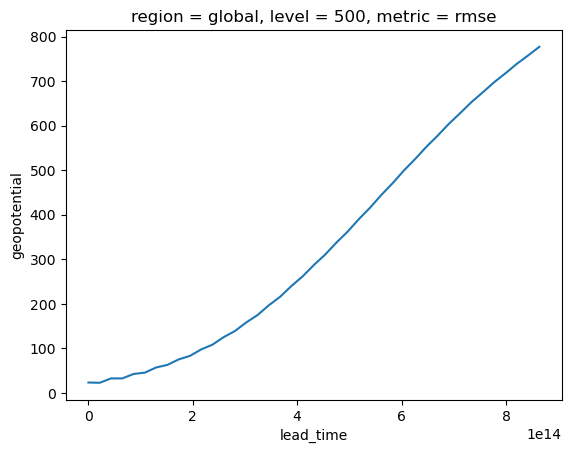

In [ ]:
results['geopotential'].sel(metric='rmse', level=500, region='global').plot();

### Next steps

This quickstart guide shows the basic functionality of the WeatherBench evaluation code but there is more to explore.

For running evaluation from the command line, see [this guide](https://weatherbench2.readthedocs.io/en/latest/command-line-scripts.html). For a complete overview of the entire evaluation workflow, check out the ["submission" guide](https://weatherbench2.readthedocs.io/en/latest/submit.html).